In [139]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [140]:
#Set device
#if cuda is available then use cuda, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [141]:
#declare parameters

input_size = 32*32 #image size = 32x32 --flatten 1024
n_classes = 10
n_epoch = 1
batch_size = 100
learning_rate = 0.001

In [142]:
#unpicke dataset to batches
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#unpickled data are dict use b'labels' , b'data to access them
batch1 = unpickle(r'/home/zacharyyeh/Datasets/CIFAR10/data_batch_1')
batch2 = unpickle(r'/home/zacharyyeh/Datasets/CIFAR10/data_batch_2')
batch3 = unpickle(r'/home/zacharyyeh/Datasets/CIFAR10/data_batch_3')
batch4 = unpickle(r'/home/zacharyyeh/Datasets/CIFAR10/data_batch_4')
batch5 = unpickle(r'/home/zacharyyeh/Datasets/CIFAR10/data_batch_5')
batch_test = unpickle(r'/home/zacharyyeh/Datasets/CIFAR10/test_batch')
train_images = np.concatenate((batch1[b'data'], batch2[b'data'], batch3[b'data'], batch4[b'data'], batch5[b'data']))
train_labels = np.concatenate((batch1[b'labels'], batch2[b'labels'], batch3[b'labels'], 
                                batch4[b'labels'], batch5[b'labels']))
test_images = batch_test[b'data']
test_labels = batch_test[b'labels']


In [143]:
train_images[0].shape

(3072,)

In [144]:
#Build children class TrainSet, TestSet from parent class Dataset 

class TrainSet(Dataset):
    def __init__(self, transform = None):
        self.train_images = train_images #[samples, flatten]
        self.train_labels = train_labels
        self.n_samples = train_images.shape[0]
        self.train_images = np.vstack(self.train_images).reshape(-1, 3, 32, 32)
        self.train_images = np.transpose(self.train_images, (0, 2, 3, 1))
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.train_images[index], self.train_labels[index]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return self.n_samples

class TestSet(Dataset):
    def __init__(self, transform = None):
        self.test_images = test_images
        self.test_labels = test_labels
        self.n_samples = test_images.shape[0]
        self.test_images = np.vstack(self.test_images).reshape(-1, 3, 32, 32)
        self.test_images = np.transpose(self.test_images, (0, 2, 3, 1))
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.test_images[index], self.test_labels[index]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return self.n_samples


#Make dataset with transform included

composed_transform = transforms.Compose([transforms.ToTensor(),
                     transforms.Normalize(mean = (0.5, 0.5, 0.5 ), std = (0.5, 0.5, 0.5))])

train_dataset = TrainSet(transform = composed_transform)
test_dataset = TestSet(transform = composed_transform)

#Make dataloader
#Note: DataLoader antomatically transform data from numpy to tensor
#But we still do ToTensor transform to Normalize(normalize require tensor dtype)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = False)

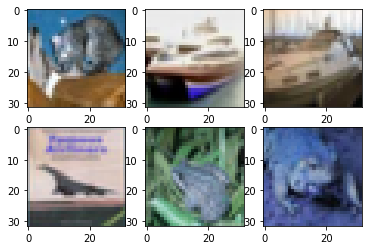

In [145]:
#Show some examples to examinate dataloader

examples = iter(test_loader)
example_images, example_labels = examples.next()

#because imshow only accept h w c image
#while training using c h w mode (for RGB mode, gray mode don't have to be transposed)
#we trapnspouse the matrix then denormalize for imshow
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.transpose(example_images[i]/2+0.5, (1, 2, 0)))
plt.show()

In [146]:
#Build a Convolutional Neural Network

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Conv = nn.Conv2d(in_channels =3, out_channels = 10, kernel_size = 3, stride = 1, padding = 1)
        self.ReLU = nn.ReLU()
        self.MaxPool = nn.MaxPool2d(2)
        self.Linear = nn.Linear(in_features = 2560 , out_features= 10)
    
    def forward(self, x):
        output = self.Conv(x) #input(batch_size ,3, 32, 32), output(batch_size, 10, 32, 32)
        output = self.ReLU(output)
        output = self.MaxPool(output) #input(batch_size, 10, 32, 32), output(batch_size, 10, 16, 16)
        #flatten input(batch_size, 10, 14, 14), output(batch_size, 2560)
        output = output.view(-1, 2560)
        #Linear input(bath_size, 2560) output(batch_size, 10)
        output = self.Linear(output)
        #we don't have to do softmax here, because we are use CrossEntropy, which softmax is included
        return output
    def featuremap(self, x):
        return self.Conv(x)

model = Model().to(device)
print(model)

Model(
  (Conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU): ReLU()
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear): Linear(in_features=2560, out_features=10, bias=True)
)


In [147]:
#Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [148]:
#Make Training Loop

steps = len(train_loader)

print('Start training...')

for epoch in range(n_epoch):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #Note: Labels are now dtype torch.uint8, should be change to torch.long for CrossEntropyLoss
        labels = labels.type(torch.long)
        labels = labels.to(device)
        #forward pass
        pred_labels = model(images)
        loss = criterion(pred_labels, labels)

        #backward pass
        loss.backward()

        #update gradients
        optimizer.step()
        optimizer.zero_grad()

        #print information in a epoch
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epoch}, step: {(i+1)}/{steps}, loss: {loss.item():.3f}')

            
print('Training is completed')

Start training...
epoch: 1/1, step: 100/500, loss: 1.791
epoch: 1/1, step: 200/500, loss: 1.516
epoch: 1/1, step: 300/500, loss: 1.443
epoch: 1/1, step: 400/500, loss: 1.578
epoch: 1/1, step: 500/500, loss: 1.315
Training is completed


In [149]:
#Test the model

#Note: In test case, we do not want to calculate the gradients
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    #you can also use for i, (images, labels) in enumerate(test_loader):
    #but now we don't care batch imformation, simple use this
    for images, labels in test_loader:
        #flatten
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        #the output is a probability distribution. We want to tranform them into integer(predicted state)
        #torch.max(tensor, dimention) will return [max tensor value, index] in a dimention of a tensor
        #here we only want the index, not the linear output(float), actually it is the predicted number
        #Note: _ here is not probability because we didn't apply softmax
        _, predicted = torch.max(output, 1)
        n_samples = n_samples + labels.shape[0]
        #Note (predicted == labels) is still a tensor with one element. We need to use item() to get a value
        #then we can compute divition
        n_correct = n_correct + (predicted == labels).sum().item()

acc = n_correct / n_samples
print(f'model accuracy: {acc:.3f}')

model accuracy: 0.507


In [150]:
#See some predictions of the model

with torch.no_grad():
    examples = iter(test_loader)
    data, actual_labels = examples.next()
    data = data.to(device)
    predicted_labels = model(data)
    _, predicted_labels = torch.max(predicted_labels, 1)

print('predicted labels:\n', predicted_labels.cpu().numpy())
print('actual labels:\n', actual_labels.numpy().squeeze())



predicted labels:
 [3 1 0 0 6 6 1 6 3 1 0 9 5 7 9 8]
actual labels:
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8]


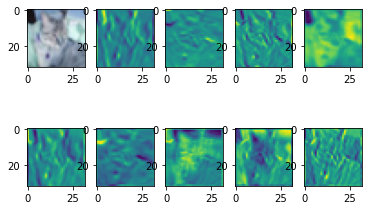

In [151]:
#show the feature map

#evaluation mode
model.eval()
img = test_dataset[8][0]
imgplot = np.transpose(img, (1, 2, 0))
#add one dimention for model input
img = img[None, :, :, :]
img = torch.FloatTensor(img).to(device)
feature_map = model.featuremap(img).detach().cpu()

plt.subplot(2, 5, 1)
#denormalize
plt.imshow(imgplot/2+0.5)

for i in range(9):
    plt.subplot(2,5,i+2)
    plt.imshow(feature_map[0, i, :, :])
plt.show()
